Epoch 50/500, Loss: 0.058649, Physics Loss: 3.395638
Epoch 100/500, Loss: 0.058575, Physics Loss: 2.531857
Epoch 150/500, Loss: 0.059542, Physics Loss: 6.322550
Epoch 200/500, Loss: 0.058899, Physics Loss: 4.087199
Epoch 250/500, Loss: 0.058266, Physics Loss: 3.971201
Epoch 300/500, Loss: 0.058343, Physics Loss: 3.036009
Epoch 350/500, Loss: 0.058190, Physics Loss: 2.258134
Epoch 400/500, Loss: 0.058470, Physics Loss: 5.021525
Epoch 450/500, Loss: 0.058276, Physics Loss: 4.571958
Epoch 500/500, Loss: 0.058933, Physics Loss: 3.373329


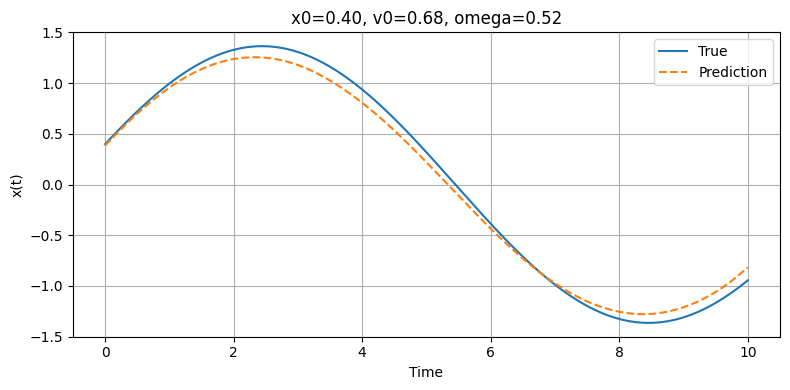

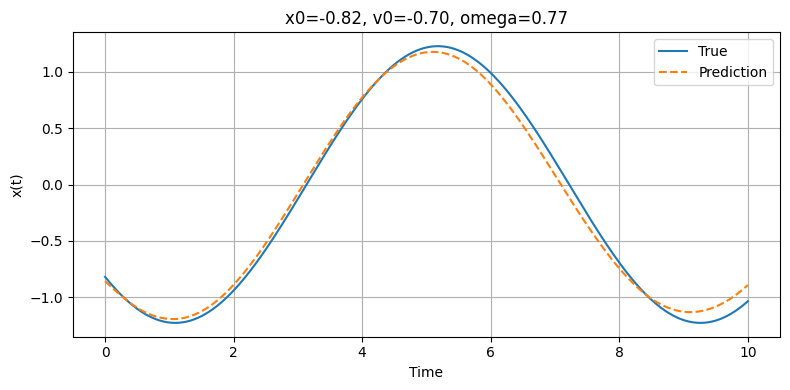

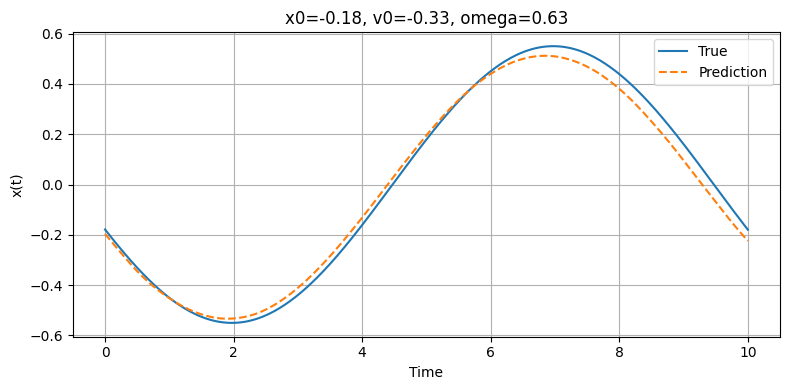

In [ ]:
# Imports 
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# Time Grid 
num_time_points = 500  # Higher resolution
T = 10.0
t = np.linspace(0, T, num_time_points)
dt = t[1] - t[0]

# Generate Training Data
num_samples = 10000
x0 = np.random.uniform(-1, 1, size=num_samples)
v0 = np.random.uniform(-1, 1, size=num_samples)
omega = np.random.uniform(0.5, 3.0, size=num_samples)

def true_solution(x0, v0, omega, t):
    return x0[:, None] * np.cos(omega[:, None] * t) + (v0[:, None] / omega[:, None]) * np.sin(omega[:, None] * t)
x = true_solution(x0, v0, omega, t)

# Normalize Input/Output 
x_mean, x_std = x.mean(), x.std()
x_normalized = (x - x_mean) / x_std
x0_n = (x0 - x0.mean()) / x0.std()
v0_n = (v0 - v0.mean()) / v0.std()
omega_n = (omega - omega.mean()) / omega.std()
# Positional Encoding 
pos_encoding = np.stack([np.sin(t), np.cos(t)], axis=1)  # (T, 2)
pos_encoding = torch.tensor(pos_encoding, dtype=torch.float32)
# Prepare Dataset 
inputs = np.stack([x0_n, v0_n, omega_n], axis=1)  # (N, 3)
inputs_expanded = np.repeat(inputs[:, None, :], num_time_points, axis=1)
pos_enc_expanded = pos_encoding[None, :, :].numpy()
pos_tiled = np.tile(pos_enc_expanded, (num_samples, 1, 1))
inputs_with_time = np.concatenate([inputs_expanded, pos_tiled], axis=2)
X_train, X_test, y_train, y_test = train_test_split(inputs_with_time, x_normalized, test_size=0.1, random_state=42) # Split data
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

from neuralop.models import FNO1d
model = FNO1d(in_channels=5, out_channels=1, n_modes_height=32, n_modes_width=32, hidden_channels=128)

# Training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
#Training Loop
epochs = 500
model.train()
for epoch in range(epochs):
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        xb = xb.permute(0, 2, 1)  # [B, C, L]
        pred = model(xb).squeeze(1)  # [B, L]
        # Physics-informed loss
        data_loss = loss_fn(pred, yb)
        pred_ddot = (pred[:, 2:] - 2 * pred[:, 1:-1] + pred[:, :-2]) / dt**2
        omega_sq = xb[:, 2, 0] * omega.std() + omega.mean()
        omega_sq = omega_sq.view(-1, 1)
        x_mid = pred[:, 1:-1] * x_std + x_mean
        physics_residual = pred_ddot + omega_sq * x_mid
        physics_loss = torch.mean(physics_residual**2)
        # Weighted loss to emphasize late time
        time_weights = torch.linspace(0.5, 1.5, num_time_points, device=device)
        weighted_data_loss = ((pred - yb)**2 * time_weights).mean()
        loss = weighted_data_loss + 0.01 * physics_loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.6f}, Physics Loss: {physics_loss.item():.6f}")

# Evaluation
model.eval()
with torch.no_grad():
    xb, yb = next(iter(test_loader))
    xb = xb.to(device)
    xb_perm = xb.permute(0, 2, 1)
    pred = model(xb_perm).squeeze(1) * x_std + x_mean
    yb = yb * x_std + x_mean
    pred = pred.cpu().numpy()
    yb = yb.cpu().numpy()
    xb = xb.cpu().numpy()

# Plot Results
for i in range(3):
    plt.figure(figsize=(8, 4))
    plt.plot(t, yb[i], label='True')
    plt.plot(t, pred[i], '--', label='Prediction')
    x0_, v0_, omega_ = xb[i, 0, 0], xb[i, 0, 1], xb[i, 0, 2]
    x0_real = x0_ * x0.std() + x0.mean()
    v0_real = v0_ * v0.std() + v0.mean()
    omega_real = omega_ * omega.std() + omega.mean()
    plt.title(f"x0={x0_real:.2f}, v0={v0_real:.2f}, omega={omega_real:.2f}")
    plt.xlabel('Time')
    plt.ylabel('x(t)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
